# Marine ecosystem modelling

> Author: Victor Boussange
> 
> Email: vic.boussange@gmail.com


We'll fit a 5 species marine ecosystem model with `PiecewiseInference.jl`.

In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
using Graphs
using EcoEvoModelZoo
using ParametricModels
using LinearAlgebra
using UnPack
using OrdinaryDiffEq
using Statistics
using SparseArrays
using ComponentArrays
using PythonPlot
using CSV
using DataFrames

  Activating project at `~/ETHZ/projects/MyTutorials/PiecewiseInference`


## Loading the data


In [2]:
df_data = CSV.read("marine_ecosystem.csv", DataFrame)
node_labels = names(df_data)[2:end]
data = Array(df_data[:, 2:end])' .|> Float32
tsteps = df_data[:, "Time stamp"] .|> Float32
const N = size(data,1)

5

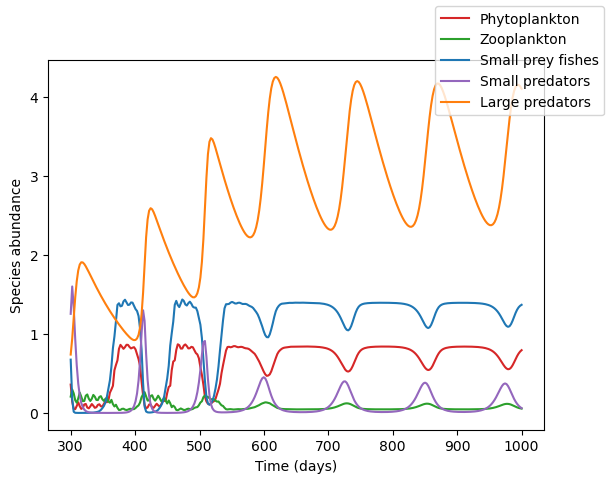

In [3]:
# plotting
using PythonPlot;
species_colors = ["tab:red", "tab:green", "tab:blue", "tab:purple", "tab:orange"]

function plot_time_series(data)
    fig, ax = subplots()
    for i in 1:N
        ax.plot(tsteps,data[i, :], label = node_labels[i], color = species_colors[i])
    end
    # ax.set_yscale("log")
    ax.set_ylabel("Species abundance")
    ax.set_xlabel("Time (days)")
    fig.set_facecolor("None")
    ax.set_facecolor("None")
    fig.legend()
    return fig
end

plot_time_series(data)

# Ecosystem model definition

### Defining hyperparameters for the forward simulation of the model.


### Defining the foodweb structure

In the model considered, we have
1. Phytoplankton
2. Zooplankton
3. Small prey fishes
4. Small predators
5. Large predators

Each of those will correspond to a node in the `foodweb` graph. We add an edge between the node when there is a feeding interaction.

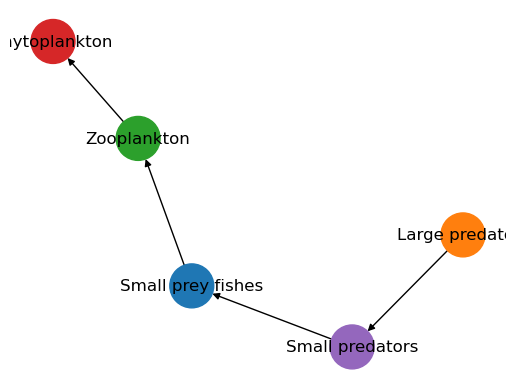

(<py Figure size 640x480 with 1 Axes>, <py Axes: >)

In [4]:
node_labels = ["Phytoplankton", 
                "Zooplankton", 
                "Small prey fishes", 
                "Small predators", 
                "Large predators"]

foodweb = DiGraph(N)
[add_edge!(foodweb, i + 1 => i) for i in 1:4]

# plotting the foodweb
using PythonCall
nx = pyimport("networkx")
np = pyimport("numpy")
species_colors = ["tab:red", "tab:green", "tab:blue", "tab:purple", "tab:orange"]
function plot_foodweb(foodweb, pos, labs)
    g_nx = nx.DiGraph(np.array(adjacency_matrix(foodweb)))

    # shifting indices
    !isnothing(pos) && (pos = Dict(keys(pos) .- 1 .=> values(pos)))
    labs = Dict(keys(labs) .- 1 .=> values(labs))

    fig, ax = subplots(1)
    nx.draw(g_nx, pos, ax=ax, node_color=species_colors, node_size=1000, labels=labs)
    ax.set_facecolor("none")
    fig.set_facecolor("none")
    display(fig)
    return fig, ax
end
plot_foodweb(foodweb, nothing, node_labels)

We implement the processes. We use `Float32`, as these are less memory demanding than default `Float64`.

In [5]:
mytype = Float32

intinsic_growth_rate(p, t) = p.r

# only phytoplanktons have a carrying capacity
function carrying_capacity(p, t)
    @unpack K₁₁ = p
    K = vcat(K₁₁, ones(mytype, N - 1))
    return K
end

# only phytoplanktons have intraspecific competition
function competition(u, p, t)
    @unpack A₁₁ = p
    A = spdiagm(vcat(A₁₁, zeros(mytype, N-1)))
    return A * u
end

resource_conversion_efficiency(p, t) = ones(mytype, N)

using SparseArrays
W = adjacency_matrix(foodweb, mytype)
I, J, _ = findnz(W)

function feeding(u, p, t)
    @unpack H, q = p

    # handling time
    H_sp = sparse(I, J, H, N, N)

    # attack rates
    q_sp = sparse(I, J, q, N, N)

    return q_sp .* W ./ (one(eltype(u)) .+ q_sp .* H_sp .* (W * u))
end

feeding (generic function with 1 method)

Down below, we define the parameters passed to the ODE solver. 
```julia
sensealg = BacksolveAdjoint(autojacvec=ReverseDiffVJP(true))
```
Defines the algorithm used to differentiate the model, and will critically affect the performance of the code.

In [6]:
using SciMLSensitivity
tsteps = range(300f0, 1000f0, length=300)
hyper_params = (alg = BS3(),
                abstol = 1e-6,
                reltol = 1e-6,
                tspan = (0f0, tsteps[end]),
                sensealg = BacksolveAdjoint(autojacvec=ReverseDiffVJP(true)),
                saveat = tsteps,
                maxiters=50_000,)

(alg = BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false)), abstol = 1.0e-6, reltol = 1.0e-6, tspan = (0.0f0, 1000.0f0), sensealg = BacksolveAdjoint{0, true, Val{:central}, ReverseDiffVJP{true}}(ReverseDiffVJP{true}(), true, false), saveat = 300.0f0:2.3411372f0:1000.0f0, maxiters = 50000)

We change the parameter values compared to the model which has generated the dataset, and try to recover the parameters

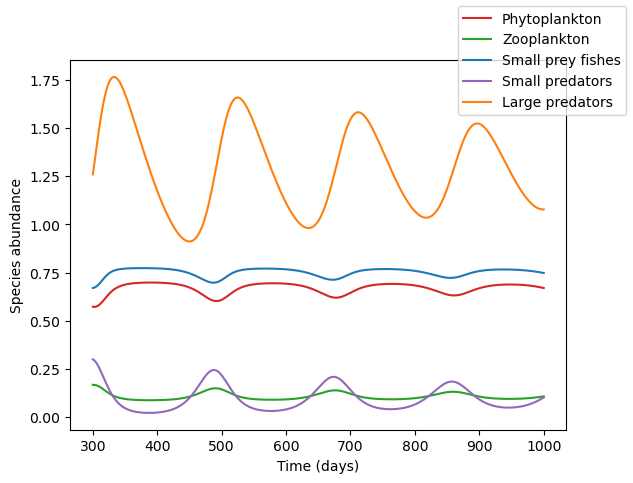

In [7]:
p_init = ComponentArray(H = [4f-1, 0.5f0, 3f0, 1f0], # handling time of [zoo, small prey, small predator, large predators]
                        q = [3f0, 1f0, 0.5f0, 1f-1],
                        r = [1f0, -0.4f0, -0.08f0, -0.05f0, -0.01f0],
                        K₁₁ = [0.9f0],
                        A₁₁ = [1.1f0])

u0_init = mytype[0.71, 0.20, 0.5, 0.4, 0.1]

mp = ModelParams(; p=p_init,
                u0=u0_init,
                hyper_params...)
model = SimpleEcosystemModel(; mp, intinsic_growth_rate,
                            carrying_capacity,
                            competition,
                            resource_conversion_efficiency,
                            feeding)

simul_model = simulate(model) |> Array;

plot_time_series(simul_model)

# Inference

In [8]:
using PiecewiseInference
using OptimizationFlux


## Definition of the loss function

Since abundances are always positive, it is a good idea to assume that the noise is log-normally distributed, and as such to log transform the data.

In [9]:
function loss_likelihood(data, pred, rng)
    if any(pred .<= 0.) # we do not tolerate non-positive ICs -
        return Inf
    elseif size(data) != size(pred) # preventing Zygote to crash
        return Inf
    end

    l = sum((log.(data) .- log.(pred)).^2)

    if l isa Number # preventing any other reason for Zygote to crash
        return l
    else 
        return Inf
    end
end
loss_likelihood(data, pred) = loss_likelihood(data, pred, nothing) # method required for loss_u0_prior in InferenceProblem

loss_likelihood (generic function with 2 methods)

## Definition of the state variable and parameter space

The parameter and state variables must be constrained, otherwise it is likely that during the optimization, the optimization algorithm proposes values for the parameters or state variables that are outside of their valid ranges, which can cause numerical errors when solving the ODE system that describes the model.

To prevent this from happening, we use bijectors to constrain the parameters and state variables to their valid ranges. A bijector is a mathematical function that maps a set of values from one space to another. In this case, we use bijectors to map the parameters and state variables from their unconstrained space, where the optimization algorithm searches for the best values, to a constrained space where their values are valid.

The Bijectors.jl package provides a collection of differentiable bijectors that can be used in Julia. By using a bijector, we can ensure that the optimization algorithm only proposes valid values for the parameters and state variables.


Here we constrain the state variables to lie in the range `[5e-3, 1e2]`

In [10]:
using Bijectors
u0_bij = bijector(Uniform(5f-3, 1f2)) # seems like stacked is not working with AD


Bijectors.TruncatedBijector{Float32, Float32}(0.005f0, 100.0f0)

And we constrain the model parameters like so

In [11]:
# constraints on parameters
distrib_param = (H = Uniform(5f-2, 4f0), # 
                q = Uniform(1f-2, 1f1), #
                r = Uniform(-1f0, 4f0), # 
                K₁₁ = Uniform(5f-1, 5f0), # 
                A₁₁ = Uniform(5f-1, 5f0))

# bijectors, to constrain parameter values and initial conditions
p_bij = NamedTuple([dp => bijector(distrib_param[dp]) for dp in keys(distrib_param)])

(H = Bijectors.TruncatedBijector{Float32, Float32}(0.05f0, 4.0f0), q = Bijectors.TruncatedBijector{Float32, Float32}(0.01f0, 10.0f0), r = Bijectors.TruncatedBijector{Float32, Float32}(-1.0f0, 4.0f0), K₁₁ = Bijectors.TruncatedBijector{Float32, Float32}(0.5f0, 5.0f0), A₁₁ = Bijectors.TruncatedBijector{Float32, Float32}(0.5f0, 5.0f0))

We feed the `model`, the initial parameters `p_init`, the loss to use for the model output and the initial state variables, as well as the bijectors, like so

In [12]:
infprob = InferenceProblem(model, p_init; 
                            loss_u0_prior = loss_likelihood, # loss applied on the initial conditions inferred
                            loss_likelihood = loss_likelihood, # loss applied on the simuation ouput
                            p_bij, u0_bij);

## PiecewiseInference hyper parameters set up
Follow the tutorial on PiecewiseInference to decide on the hyperparameter `group_size` and `batchsizes`. As a rule of thumb, if the loss seems choppy, reduce `group_size`, if it is too smooth, increase `group_size`. Notice that the learning rate can also affect this property of the loss over the iteration. For `batchsizes`, let it be as large as it can be, given the time it takes for an iteration.

In [16]:
@time res = piecewise_MLE(infprob;
                        adtype = Optimization.AutoZygote(),
                        group_size = 31,
                        batchsizes = [10],
                        data = data,
                        tsteps = tsteps,
                        optimizers = [Adam(1e-2)],
                        epochs = [500],
                        verbose_loss = true,
                        info_per_its = 10,
                        multi_threading = false)

piecewise_MLE with 300 points and 10 groups.


┌ Info: Training started
└ @ PiecewiseInference /Users/victorboussange/ETHZ/projects/PiecewiseInference.jl/src/piecewise_MLE.jl:270
┌ Info: Running optimizer Adam
└ @ PiecewiseInference /Users/victorboussange/ETHZ/projects/PiecewiseInference.jl/src/piecewise_MLE.jl:441


Current loss after 10 iterations: 3070.684814453125


Current loss after 20 iterations: 1070.0753173828125


Current loss after 30 iterations: 521.5565795898438


Current loss after 40 iterations: 498.4069519042969


Current loss after 50 iterations: 367.1812438964844


Current loss after 60 iterations: 332.3791198730469


Current loss after 70 iterations: 307.82550048828125


Current loss after 80 iterations: 296.05230712890625


Current loss after 90 iterations: 285.2601318359375


Current loss after 100 iterations: 276.1634216308594


Current loss after 110 iterations: 267.7752380371094


Current loss after 120 iterations: 258.8412780761719


Current loss after 130 iterations: 247.16929626464844


Current loss after 140 iterations: 233.6175537109375


Current loss after 150 iterations: 222.70111083984375


Current loss after 160 iterations: 216.0438232421875


Current loss after 170 iterations: 211.96524047851562


Current loss after 180 iterations: 208.92898559570312


Current loss after 190 iterations: 206.29478454589844


Current loss after 200 iterations: 203.82666015625


Current loss after 210 iterations: 201.47998046875


Current loss after 220 iterations: 199.2188720703125


Current loss after 230 iterations: 197.0334930419922


Current loss after 240 iterations: 194.91598510742188


Current loss after 250 iterations: 192.85877990722656


Current loss after 260 iterations: 190.85610961914062


Current loss after 270 iterations: 188.90174865722656


Current loss after 280 iterations: 186.98973083496094


Current loss after 290 iterations: 185.11651611328125


Current loss after 300 iterations: 183.2781219482422


Current loss after 310 iterations: 181.46783447265625


Current loss after 320 iterations: 179.68017578125


Current loss after 330 iterations: 177.91529846191406


Current loss after 340 iterations: 176.16859436035156


Current loss after 350 iterations: 174.43472290039062


Current loss after 360 iterations: 172.71060180664062


Current loss after 370 iterations: 170.9961395263672


Current loss after 380 iterations: 169.28518676757812


Current loss after 390 iterations: 167.57508850097656


Current loss after 400 iterations: 165.86807250976562


Current loss after 410 iterations: 164.1543426513672


Current loss after 420 iterations: 162.4386444091797


Current loss after 430 iterations: 160.71299743652344


Current loss after 440 iterations: 158.98081970214844


Current loss after 450 iterations: 157.2406768798828


Current loss after 460 iterations: 155.4927978515625


Current loss after 470 iterations: 153.74363708496094


Current loss after 480 iterations: 151.9927520751953


Current loss after 490 iterations: 150.24917602539062


Current loss after 500 iterations: 148.51661682128906


320.931238 seconds (2.17 G allocations: 406.946 GiB, 12.01% gc time, 1.45% compilation time)


┌ Info: Minimum loss for all batches: 148.5166473388672
└ @ PiecewiseInference /Users/victorboussange/ETHZ/projects/PiecewiseInference.jl/src/piecewise_MLE.jl:287


`InferenceResult` with model SimpleEcosystemModel


Dashed lines correspond to data, plain lines correspond to predictions, over chunks

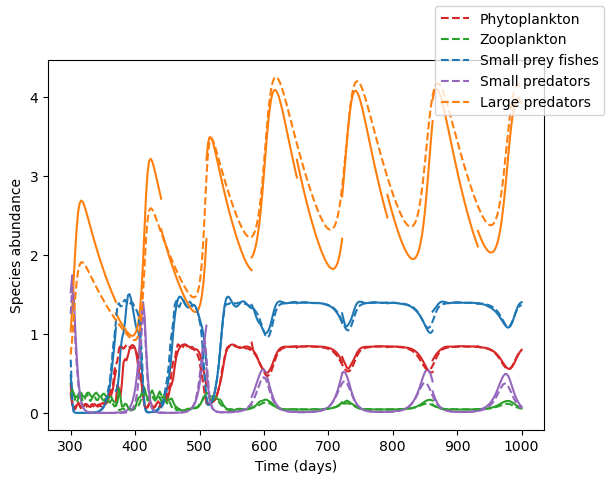

In [39]:
fig, ax = subplots()
for j in 1:length(res.ranges) # looping through all segments
    for i in 1:N # looping through all species
        ax.plot(tsteps[res.ranges[j]], res.pred[j][i,:], color = species_colors[i])
    end
end

for i in 1:N
    ax.plot(tsteps, data[i, :], color = species_colors[i], label = node_labels[i], linestyle = "--")

end
# ax.set_yscale("log")
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

Let's run the trained model over a longer time range than what it's been trained over.

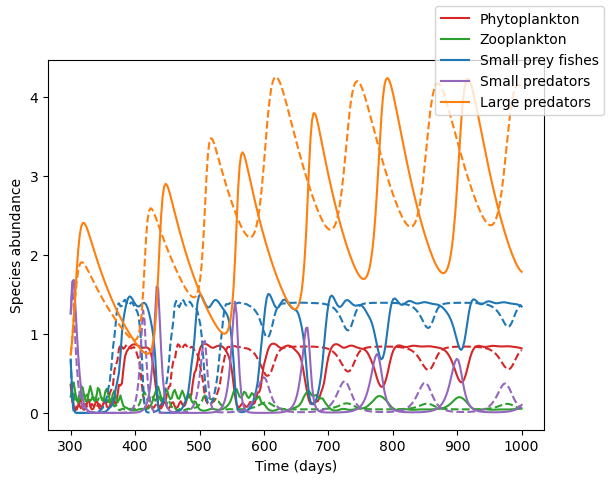

300.0f0:2.3411372f0:1000.0f0

In [40]:
fig, ax = subplots()
predictions = simulate(model, 
                        p = res.p_trained, 
                        # u0 = res.u0s_trained[1], 
                        u0 = data[:,1],
                        tspan = (tsteps[1], tsteps[end]))
for i in 1:N
    ax.plot(tsteps, predictions[i, :], label = node_labels[i], color = species_colors[i])
    ax.plot(tsteps, data[i, :], color = species_colors[i], linestyle = "--")

end
# ax.set_yscale("log")
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

tsteps

Although we do observe discrepancies, the recovered behavior is consistent.